In [27]:
import arcpy
import arcview
from arcpy import env
import numpy as np
import matplotlib.pyplot as plt
import gdal

%run D:\Python_Functions\FolderCreater.py
%run D:\Python_Functions\TellExtent.py
%run D:\Python_Functions\1_Modified_VSSIXA_Functions\WriteTiffData.py
%run C:\Users\grui9\Box\GitHub_Rui\Python_Functions\TellTheGeoInfo.py

# Define parameters and folder paths

In [52]:
Flight_Date = "20200904"
Research_Grids = r'D:\Project_Wellsville\13_2nd_flight_2020\1_ArcGIS_0904\Well0904_Grids_1m.shp'
AggieAir_Spectral = r'D:\Project_Wellsville\0_Data\20200903_Wellsville\20200903_wellsville_dragonfly_micasense_120m_bgrrenirtir_ThermalBias_Mosaic.tif'
dir_output = r'D:\Project_Wellsville\13_2nd_flight_2020\3_Model_Process_1'
FolderCreater(dir_output)

CellSize = "0.1 0.1"
NoDataValue = -9999
ThermalNoDataValue = np.nan
band_G = 1
band_R = 2
band_RE = 3
band_NIR = 4
band_Tr = 5
GridSize = 1 # meter
h_corn = 2.5
h_alf = 0.2
h_mar = 1.1
h_road = 0
# give imperical values avoiding inf values
LAI_max_value = 4.5
w_h_ratio_max = 10

# Image pre-processing
Resample and align the image data

In [29]:
# Resample
arcpy.Resample_management(in_raster=AggieAir_Spectral, 
                          out_raster=dir_output+"\\"+Flight_Date+"_res.tif", 
                          cell_size=CellSize, 
                          resampling_type="NEAREST")

<Result 'D:\\Project_Wellsville\\13_2nd_flight_2020\\3_Model_Process_1\\20200904_res.tif'>

In [30]:
rectangle_extent = TellExtent(Research_Grids)
# Align the image with the grids
arcpy.Clip_management(in_raster=dir_output+"\\"+Flight_Date+"_res.tif", 
                      rectangle=rectangle_extent, 
                      out_raster=dir_output+"\\"+Flight_Date+"_clip.tif", 
                      in_template_dataset=Research_Grids, 
                      nodata_value=NoDataValue, 
                      clipping_geometry="NONE", maintain_clipping_extent="MAINTAIN_EXTENT")

The extent is: 423220.5553930541 4612315.669819682 423836.5553930541 4612809.669819682


<Result 'D:\\Project_Wellsville\\13_2nd_flight_2020\\3_Model_Process_1\\20200904_clip.tif'>

# Vegetation index calculation
Using NDVI to recognize the soil and vegetation, and also export several VIs raster data.

In [31]:
# get the information from the cliped imagery
# resolution is 0.1*0.1
[dims,img_geo,img_prj] = TellTheGeoInfo(dir_output+"\\"+Flight_Date+"_clip.tif")

Dimension of the data is: 4940 6160


C:\Users\grui9\anaconda3\envs\TSEB\lib\site-packages\ipykernel_launcher.py:5: RuntimeWarning: invalid value encountered in true_divide
  """
C:\Users\grui9\anaconda3\envs\TSEB\lib\site-packages\ipykernel_launcher.py:6: RuntimeWarning: divide by zero encountered in true_divide
  
C:\Users\grui9\anaconda3\envs\TSEB\lib\site-packages\ipykernel_launcher.py:6: RuntimeWarning: invalid value encountered in true_divide
  


D:\Project_Wellsville\13_2nd_flight_2020\3_Model_Process_1\20200904_NDVI.tif
Done!!! Tiff data has been written.
D:\Project_Wellsville\13_2nd_flight_2020\3_Model_Process_1\20200904_CI_re.tif
Done!!! Tiff data has been written.
D:\Project_Wellsville\13_2nd_flight_2020\3_Model_Process_1\20200904_MCARI1.tif
Done!!! Tiff data has been written.


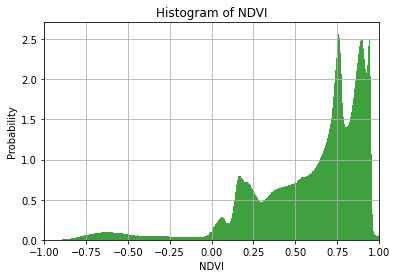

In [32]:
# NDVI calculation and histogram
# CI_RE calculation for LAI calculation for Corn
Array_Spectral = arcpy.RasterToNumPyArray(dir_output+"\\"+Flight_Date+"_clip.tif", 
                                          nodata_to_value=NoDataValue)
NDVI = (Array_Spectral[band_NIR,:,:]-Array_Spectral[band_R,:,:])/(Array_Spectral[band_NIR,:,:]+Array_Spectral[band_R,:,:])
CI_RE = Array_Spectral[band_NIR,:,:]/Array_Spectral[band_RE,:,:]-1
MCARI1 = 2*(Array_Spectral[band_NIR,:,:]-Array_Spectral[band_R,:,:]-0.2*(Array_Spectral[band_NIR,:,:]-Array_Spectral[band_G,:,:]))
WriteTiffData(dir_output, Flight_Date+"_NDVI", dims[0], dims[1], NDVI, img_geo, img_prj)
WriteTiffData(dir_output, Flight_Date+"_CI_re", dims[0], dims[1], CI_RE, img_geo, img_prj)
WriteTiffData(dir_output, Flight_Date+"_MCARI1", dims[0], dims[1], MCARI1, img_geo, img_prj)

# the histogram of the data
NDVI_hist = NDVI.reshape(-1)
n, bins, patches = plt.hist(NDVI_hist, 1000, density=True, facecolor='g', alpha=0.75)
plt.xlabel('NDVI')
plt.ylabel('Probability')
plt.title('Histogram of NDVI')
# plt.text(60, .025, r'$\mu=100,\ \sigma=15$')
plt.xlim(-1, 1)
# plt.ylim(0, 0.03)
plt.grid(True)
plt.show()

# Fractional cover and canopy width
We need manually to find the threshold to defind the vegetation index

In [33]:
# NDVI threshold from histogram for vegetation
NDVI_threshold = 0.35

In [34]:
# Using the threshold to identify the vegetation pixel and non-vegetation index
Veg_logic = NDVI.copy()
Veg_logic[Veg_logic >= NDVI_threshold] = 1
Veg_logic[Veg_logic < NDVI_threshold] = 0
WriteTiffData(dir_output, Flight_Date+"_Veg", dims[0], dims[1], Veg_logic, img_geo, img_prj)

D:\Project_Wellsville\13_2nd_flight_2020\3_Model_Process_1\20200904_Veg.tif
Done!!! Tiff data has been written.


()

In [35]:
# Zonal statistics as table - for fractional cover
arcpy.gp.ZonalStatisticsAsTable_sa(Research_Grids, "FID", dir_output+"\\"+Flight_Date+"_Veg.tif", 
                                   dir_output+"\\"+Flight_Date+"_Zonal.dbf", "DATA", "SUM")

<geoprocessing server result object at 0x1f8e670a180>

In [36]:
# add a new field and then get the fractional cover
# arcpy.AddField_management(Research_Grids, "FC", "Double", field_length=20)
arcpy.CalculateField_management(in_table=dir_output+"\\"+Flight_Date+"_Zonal.dbf", 
                                field="FC", 
                                expression="!SUM! / !COUNT!", 
                                expression_type="PYTHON_9.3", code_block="")

<Result 'D:\\Project_Wellsville\\13_2nd_flight_2020\\3_Model_Process_1\\20200904_Zonal.dbf'>

In [38]:
# Join the table and then output it as a raster 
arcpy.JoinField_management(in_data=Research_Grids, 
                           in_field="FID", 
                           join_table=dir_output+"\\"+Flight_Date+"_Zonal.dbf", 
                           join_field="FID_", 
                           fields="FC")

<Result 'D:\\Project_Wellsville\\13_2nd_flight_2020\\1_ArcGIS_0904\\Well0904_Grids_1m.shp'>

In [40]:
# output the fractional cover and canopy width as raster format
arcpy.FeatureToRaster_conversion(in_features=Research_Grids, 
                                 field="FC", 
                                 out_raster=dir_output+"\\"+Flight_Date+"_Fc.tif", 
                                 cell_size=GridSize)
# This one works only when the grid size is 1 meter
arcpy.FeatureToRaster_conversion(in_features=Research_Grids, 
                                 field="FC", 
                                 out_raster=dir_output+"\\"+Flight_Date+"_C_w.tif", 
                                 cell_size=GridSize)

<Result 'D:\\Project_Wellsville\\13_2nd_flight_2020\\3_Model_Process_1\\20200904_C_w.tif'>

# Canopy height 
Manually assign canopy height based on the objectives

In [41]:
# assign canopy height for different canopy type
arcpy.management.CalculateField(Research_Grids,
                                "Ch", 
                                "canopyheight(!Id!)", 
                                "PYTHON3", 
                                """def canopyheight(ID):
    if ID == 1:
        hc = 2.5
    elif ID == 2:
        hc = 0.2
    elif ID == 3:
        hc = 0.2
    elif ID == 4:
        hc = 1.1
    elif ID == 5:
        hc = 0
    elif ID == 6:
        hc = 0
    return(hc)
""", "DOUBLE")
arcpy.FeatureToRaster_conversion(in_features=Research_Grids, 
                                 field="Ch", 
                                 out_raster=dir_output+"\\"+Flight_Date+"_C_h.tif", 
                                 cell_size=GridSize)

<Result 'D:\\Project_Wellsville\\13_2nd_flight_2020\\3_Model_Process_1\\20200904_C_h.tif'>

# The ratio between canopy width and canopy height

In [42]:
# resolution is 1*1 meter
[dims,img_geo,img_prj] = TellTheGeoInfo(dir_output+"\\"+Flight_Date+"_C_w.tif")
Array_width = arcpy.RasterToNumPyArray(dir_output+"\\"+Flight_Date+"_C_w.tif", 
                                          nodata_to_value=NoDataValue)
Array_height = arcpy.RasterToNumPyArray(dir_output+"\\"+Flight_Date+"_C_h.tif", 
                                          nodata_to_value=NoDataValue)
Array_ratio = Array_width/Array_height
Array_ratio[Array_ratio>w_h_ratio_max]=w_h_ratio_max

WriteTiffData(dir_output, Flight_Date+"_w_h", dims[0], dims[1], Array_ratio, img_geo, img_prj)

Dimension of the data is: 494 616
D:\Project_Wellsville\13_2nd_flight_2020\3_Model_Process_1\20200904_w_h.tif
Done!!! Tiff data has been written.


C:\Users\grui9\anaconda3\envs\TSEB\lib\site-packages\ipykernel_launcher.py:7: RuntimeWarning: divide by zero encountered in true_divide
  import sys


()

# LAI estimation
Need to manually modify the LAI value based on the canopy type

In [43]:
# Zonal statistics as table
arcpy.gp.ZonalStatisticsAsTable_sa(Research_Grids, "FID", dir_output+"\\"+Flight_Date+"_CI_re.tif", 
                                   dir_output+"\\"+Flight_Date+"_CIreAvg.dbf", "DATA", "MEAN")
arcpy.gp.ZonalStatisticsAsTable_sa(Research_Grids, "FID", dir_output+"\\"+Flight_Date+"_NDVI.tif", 
                                   dir_output+"\\"+Flight_Date+"_NDVIAvg.dbf", "DATA", "MEAN")
arcpy.gp.ZonalStatisticsAsTable_sa(Research_Grids, "FID", dir_output+"\\"+Flight_Date+"_MCARI1.tif", 
                                   dir_output+"\\"+Flight_Date+"_MCARI1Avg.dbf", "DATA", "MEAN")

<geoprocessing server result object at 0x1f881dd4d20>

In [45]:
# join the field
arcpy.management.JoinField(Research_Grids, 
                           "FID", 
                           dir_output+"\\"+Flight_Date+"_CIreAvg.dbf", 
                           "FID_", 
                           "MEAN")
arcpy.management.JoinField(Research_Grids, 
                           "FID", 
                           dir_output+"\\"+Flight_Date+"_NDVIAvg.dbf", 
                           "FID_", 
                           "MEAN")
arcpy.management.JoinField(Research_Grids, 
                           "FID", 
                           dir_output+"\\"+Flight_Date+"_MCARI1Avg.dbf", 
                           "FID_", 
                           "MEAN")

<Result 'D:\\Project_Wellsville\\13_2nd_flight_2020\\1_ArcGIS_0904\\Well0904_Grids_1m.shp'>

In [46]:
# feature to raster
arcpy.conversion.FeatureToRaster(in_features=Research_Grids, 
                                 field="MEAN", 
                                 out_raster=dir_output+"\\"+Flight_Date+"_CIre_Avg.tif", 
                                 cell_size=GridSize)
arcpy.conversion.FeatureToRaster(in_features=Research_Grids, 
                                 field="MEAN_1", 
                                 out_raster=dir_output+"\\"+Flight_Date+"_NDVI_Avg.tif", 
                                 cell_size=GridSize)
arcpy.conversion.FeatureToRaster(in_features=Research_Grids, 
                                 field="MEAN_12", 
                                 out_raster=dir_output+"\\"+Flight_Date+"_MCARI1_Avg.tif", 
                                 cell_size=GridSize)

<Result 'D:\\Project_Wellsville\\13_2nd_flight_2020\\3_Model_Process_1\\20200904_MCARI1_Avg.tif'>

In [53]:
# point to raster
# assign canopy height for different canopy type
# ID == 1: corn
# ID == 2 or 3: alfalfa
# ID == 4: marijuana
# ID == 5: road
# ID == 6: unknown place
arcpy.management.CalculateField(Research_Grids, 
                                "LAI", 
                                "laicalculation(!Id!,!MEAN!,!MEAN_1!)", 
                                "PYTHON3", 
                                """def laicalculation(ID,CI_re,NDVI):
    if ID == 1:
        laifc = 0.5574*CI_re+0.5617
    elif ID == 2:
        laifc = 3.5255*NDVI**1.8485
    elif ID == 3:
        laifc = 3.5255*NDVI**1.8485
    elif ID == 4:
        laifc = 0.2853*CI_re+0.2604
    elif ID == 5:
        laifc = 0
    elif ID == 6:
        laifc = 0
    return(laifc)""", "DOUBLE")

<Result 'D:\\Project_Wellsville\\13_2nd_flight_2020\\1_ArcGIS_0904\\Well0904_Grids_1m.shp'>

In [54]:
# write feature to raster
# output the LAI*Fc as an image - LAI*Fc is the LAI value for the domain
arcpy.conversion.FeatureToRaster(in_features=Research_Grids, 
                                 field="LAI", 
                                 out_raster=dir_output+"\\"+Flight_Date+"_LAI_tmp.tif", 
                                 cell_size=GridSize)
# force negative LAI values to 0
Array_LAI = arcpy.RasterToNumPyArray(dir_output+"\\"+Flight_Date+"_LAI_tmp.tif", 
                                          nodata_to_value=NoDataValue)
Array_LAI[Array_LAI<0] = 0
Array_LAI[Array_LAI>LAI_max_value] = LAI_max_value
WriteTiffData(dir_output, Flight_Date+"_LAI", dims[0], dims[1], Array_LAI, img_geo, img_prj)

D:\Project_Wellsville\13_2nd_flight_2020\3_Model_Process_1\20200904_LAI.tif
Done!!! Tiff data has been written.


()

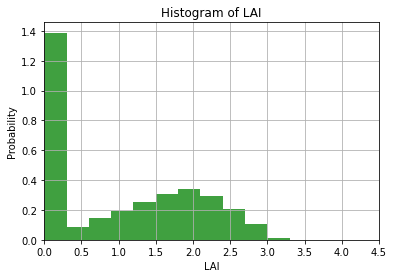

In [62]:
# the histogram of the LAI
LAI_hist = Array_LAI.reshape(-1)
n, bins, patches = plt.hist(LAI_hist, 15, density=True, facecolor='g', alpha=0.75)
plt.xlabel('LAI')
plt.ylabel('Probability')
plt.title('Histogram of LAI')
plt.xlim(0, LAI_max_value)
plt.grid(True)
plt.show()

# Upscaling the thermal data

In [49]:
# extract thermal band from the original bands
[dims,img_geo,img_prj] = TellTheGeoInfo(AggieAir_Spectral)
Array_tr_tmp = arcpy.RasterToNumPyArray(AggieAir_Spectral,
                                        nodata_to_value=ThermalNoDataValue)
WriteTiffData(dir_output, Flight_Date+"_Tr", dims[0], dims[1], Array_tr_tmp[band_Tr,:,:], img_geo, img_prj)
# upscale to energy level
Array_tr_cal = arcpy.RasterToNumPyArray(dir_output+"\\"+Flight_Date+"_Tr.tif",
                                        nodata_to_value=ThermalNoDataValue)
Array_tr_cal = Array_tr_cal**4
WriteTiffData(dir_output, Flight_Date+"_Tr_Energy", dims[0], dims[1], Array_tr_cal, img_geo, img_prj)

Dimension of the data is: 13213 19518
D:\Project_Wellsville\13_2nd_flight_2020\3_Model_Process_1\20200904_Tr.tif
Done!!! Tiff data has been written.
D:\Project_Wellsville\13_2nd_flight_2020\3_Model_Process_1\20200904_Tr_Energy.tif
Done!!! Tiff data has been written.


()

In [50]:
# adjust the grid size on the energy level
arcpy.Resample_management(dir_output+"\\"+Flight_Date+"_Tr_Energy.tif", 
                          out_raster=dir_output+"\\"+Flight_Date+"_Tr_res.tif",
                          cell_size=GridSize, 
                          resampling_type="NEAREST")
arcpy.Clip_management(in_raster=dir_output+"\\"+Flight_Date+"_Tr_res.tif",
                      rectangle=rectangle_extent, 
                      out_raster=dir_output+"\\"+Flight_Date+"_Tr_Cliped.tif", 
                      in_template_dataset=Research_Grids, 
                      nodata_value=NoDataValue, 
                      clipping_geometry="NONE", maintain_clipping_extent="MAINTAIN_EXTENT")

<Result 'D:\\Project_Wellsville\\13_2nd_flight_2020\\3_Model_Process_1\\20200904_Tr_Cliped.tif'>

In [51]:
[dims,img_geo,img_prj] = TellTheGeoInfo(dir_output+"\\"+Flight_Date+"_Tr_Cliped.tif",)
Array_tr_cal = arcpy.RasterToNumPyArray(dir_output+"\\"+Flight_Date+"_Tr_Cliped.tif",
                                        nodata_to_value=ThermalNoDataValue)
Array_tr_cal = np.sqrt(np.sqrt(Array_tr_cal))
Array_tr_cal = Array_tr_cal + 273.15
WriteTiffData(dir_output, Flight_Date+"_Tr_Final", dims[0], dims[1], Array_tr_cal, img_geo, img_prj)

Dimension of the data is: 494 616
D:\Project_Wellsville\13_2nd_flight_2020\3_Model_Process_1\20200904_Tr_Final.tif
Done!!! Tiff data has been written.


()